In [1]:
pip install -U kaleido

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Faremos a leitura de duas tabelas.

Uma constando todas as informações de cadastro de cada cliente e outra contendo cada transação.



In [4]:
df= pd.read_csv('/content/drive/My Drive/DataSet/application_record.csv', encoding= 'utf-8')
record= pd.read_csv('/content/drive/My Drive/DataSet/credit_record.csv', encoding = 'utf-8')

In [5]:
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


Meu intuito é levar informações da tabela de transações para a tabela de clientes com base na chave primária "ID".
A princípio, farei um agrupamento a fim de descobrir há quantos meses que data a primeira transação do cliente. Ao estar de posse deste dado, farei um JOIN com a tabela df, obtendo, portanto, o tempo que tal cliente está utilizando os serviços da empresa.

In [6]:

begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'})
new_data=pd.merge(df,begin_month,how="left",on="ID")

In [7]:
begin_month.index.nunique()

45985

In [8]:
df['ID'].nunique()

438510

Somente uma minoria dos clientes(representados pelo "ID") estão presentes na tabela "record". Por isso, ao realizar o join, obtemos muitos valores nulos. )

In [9]:
new_data.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
begin_month            402100
dtype: int64

Estamos considerando como usuários arriscados somente aqueles cuja dívida ultrapassa 60 dias de inadimplência. STATUS a partir de 2, segundo condições previamente estabelecidas ao extrair os dados.

In [10]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes'
record['dep_value'][record['STATUS'] =='3']='Yes'
record['dep_value'][record['STATUS'] =='4']='Yes'
record['dep_value'][record['STATUS'] =='5']='Yes'




Caso haja algum cliente com qualquer transação classificada com STATUS arriscado, devemos configurar a variável alvo como 1, caso contrário, 0.
Desta forma, seremos capazes de configurar um rótulo coerente para a análise.

In [11]:
record

,ID,MONTHS_BALANCE,STATUS,dep_value
0,5001711,0,X,None
1,5001711,-1,0,None
2,5001711,-2,0,None
3,5001711,-3,0,None
4,5001712,0,C,None
...,...,...,...,...
1048570,5150487,-25,C,None
1048571,5150487,-26,C,None
1048572,5150487,-27,C,None
1048573,5150487,-28,C,None


Agora que temos o Status de cada transação com base no tempo de pagamento, sendo este adimplente ou inadimplente, faremos outro agrupamento.
Desta forma, estabeleremos a condição de que o cliente será arriscado(Status=1) caso possua algum valor no COUNT da feature "dep_value", caso não, não será arriscado(0).

In [12]:
cpunt=record.groupby('ID').count() # Agrupando por ID

cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cpunt= cpunt.rename(columns={'dep_value':'status'})
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')


# Descritiva

| Coluna               | Descrição                                                                                      |
|----------------------|------------------------------------------------------------------------------------------------|
| ID                   | Identificador único para cada registro no DataFrame.                                            |
| CODE_GENDER          | Gênero do titular do cartão de crédito (M para masculino, F para feminino).                     |
| FLAG_OWN_CAR         | Indica se o titular do cartão de crédito possui carro (1 para possui, 0 para não possui).       |
| FLAG_OWN_REALTY      | Indica se o titular do cartão de crédito possui propriedade imobiliária (1 para possui, 0 para não possui). |
| CNT_CHILDREN         | Número de filhos do titular do cartão de crédito.                                               |
| AMT_INCOME_TOTAL     | Rendimento Anual.
| NAME_INCOME_TYPE     | Tipo de fonte de renda.
| NAME_EDUCATION_TYPE  | Nível de educação.                                            |
| NAME_FAMILY_STATUS   | Estado civil do titular do cartão de crédito.                                                   |
| NAME_HOUSING_TYPE    | Tipo de habitação do titular do cartão de crédito.                                              |
| DAYS_BIRTH           | Quantidade de dias desde o nascimento.                           |
| DAYS_EMPLOYED        | Quantidade de dias de emprego.                                   |
| FLAG_MOBIL           | Indica se o titular do cartão de crédito possui telefone celular (1 para possui, 0 para não possui). |
| FLAG_WORK_PHONE      | Indica se o titular do cartão de crédito possui telefone de trabalho (1 para possui, 0 para não possui). |
| FLAG_PHONE           | Indica se o titular do cartão de crédito possui telefone (1 para possui, 0 para não possui).   |
| FLAG_EMAIL           | Indica se o titular do cartão de crédito possui endereço de e-mail (1 para possui, 0 para não possui). |
| OCCUPATION_TYPE      | Tipo de ocupação do titular do cartão de crédito.                                               |
| CNT_FAM_MEMBERS      | Número de membros da família do titular do cartão de crédito.                                   |


In [13]:
new_data = new_data.rename(columns={
    'ID': 'id',
    'CODE_GENDER': 'genero',
    'FLAG_OWN_CAR': 'possui_carro',
    'FLAG_OWN_REALTY': 'possui_imovel',
    'CNT_CHILDREN': 'qtd_filhos',
    'AMT_INCOME_TOTAL': 'renda_total',
    'NAME_INCOME_TYPE': 'tipo_renda',
    'NAME_EDUCATION_TYPE': 'escolaridade',
    'NAME_FAMILY_STATUS': 'estado_civil',
    'NAME_HOUSING_TYPE': 'tipo_habitacao',
    'DAYS_BIRTH': 'dias_nascimento',
    'DAYS_EMPLOYED': 'dias_empregado',
    'FLAG_MOBIL': 'possui_celular',
    'FLAG_WORK_PHONE': 'possui_telefone_trabalho',
    'FLAG_PHONE': 'possui_telefone',
    'FLAG_EMAIL': 'possui_email',
    'OCCUPATION_TYPE': 'tipo_ocupacao',
    'CNT_FAM_MEMBERS': 'qtd_membros_familia',
    'begin_month': 'meses_desde_inicio'
})

In [14]:
new_data.head()

,id,genero,possui_carro,possui_imovel,qtd_filhos,renda_total,tipo_renda,escolaridade,estado_civil,tipo_habitacao,dias_nascimento,dias_empregado,possui_celular,possui_telefone_trabalho,possui_telefone,possui_email,tipo_ocupacao,qtd_membros_familia,meses_desde_inicio,status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,No
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,No
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No


# Transformação de variáveis

In [15]:
new_data['dias_empregado']=round(new_data['dias_empregado']/365,1) # Transformei a variável dias empregados em anos, com uma casa decimal, para facilitar a visualização.
new_data=new_data.rename(columns={'dias_empregado': 'anos_empregado'})

In [16]:
idade= round(-(new_data['dias_nascimento']/365)) #transformando a variável 'dias_nascimento' em idade.
new_data['dias_nascimento']= idade
new_data=new_data.rename(columns={'dias_nascimento': 'idade'})

In [17]:
salario= (new_data['renda_total']/12) #transformando a variável 'renda_total' em salario.
new_data['renda_total']= salario
new_data=new_data.rename(columns={'renda_total': 'salario'})

# Quais perguntas nós queremos responder através dos dados?




1- De que forma a posse de bens, desde os de menor porte(celular, telefone), aos de maior porte(imóvel, carro) influencia no status do cliente? Há influência?

2- De que forma as variáveis demográficas se relacionam com o status? Alguma possui papel representativo na variável alvo?

3- Possivelmente, levar o rendimento anual em consideração é importante ao definir se o crédito será concedido ou não. Clientes com rendas maiores são melhores pagadores?

4- O tipo de habitação traz-nos alguma informação em relação à variável alvo ou é pouco relevante? Quem tem casa/apartamento próprio tem menos tendência a não pagar as dívidas?

5- O tempo contínuo total que o cliente possui empregado faz o status ter algum comportamento peculiar?

6- E a idade? Clientes mais jovens são menos prudentes e, por conseguinte, mais inadimplentes?




In [18]:
display(new_data.describe())

,id,qtd_filhos,salario,idade,anos_empregado,possui_celular,possui_telefone_trabalho,possui_telefone,possui_email,qtd_membros_familia,meses_desde_inicio
count,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,15557.144722,43.777382,162.370264,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,8482.435540,11.519211,377.139623,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2250.000000,21.000000,-43.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,10125.000000,34.000000,-8.600000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,13125.000000,43.000000,-4.300000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,18750.000000,53.000000,-1.100000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,131250.000000,69.000000,1000.700000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


## Corrigindo tipos das variáveis

In [19]:
new_data.dtypes

id                            int64
genero                       object
possui_carro                 object
possui_imovel                object
qtd_filhos                    int64
salario                     float64
tipo_renda                   object
escolaridade                 object
estado_civil                 object
tipo_habitacao               object
idade                       float64
anos_empregado              float64
possui_celular                int64
possui_telefone_trabalho      int64
possui_telefone               int64
possui_email                  int64
tipo_ocupacao                object
qtd_membros_familia         float64
meses_desde_inicio          float64
status                       object
dtype: object

In [20]:
new_data['idade'] = new_data['idade'].astype(int)
new_data['qtd_membros_familia'] = new_data['qtd_membros_familia'].astype(int)
new_data['possui_telefone_trabalho'] = new_data['possui_telefone_trabalho'].astype(str)
new_data['possui_telefone'] = new_data['possui_telefone'].astype(str)
new_data['possui_email'] = new_data['possui_email'].astype(str)
new_data['meses_desde_inicio'] = new_data['meses_desde_inicio'].astype(int)

In [21]:
new_data['anos_empregado']= new_data['anos_empregado']*(-1) #Por algum motivo, esta variável é negativa. Fizemos a transformação.

In [22]:
new_data['anos_empregado'].isnull().sum()

0

### Limpeza de valores nulos/duplicados

In [23]:

# Calcular a quantidade de valores nulos por variável
null_counts = new_data.isnull().sum()

# Calcular a porcentagem de valores nulos em relação a cada variável
null_percentages = round((null_counts / len(new_data)) * 100,2)

# Exibir a quantidade de valores nulos por variável
print("Quantidade de valores nulos por variável:")
print(null_counts)

# Exibir a porcentagem de valores nulos em relação a cada variável
print("\nPorcentagem de valores nulos em relação a cada variável:")
print(null_percentages)


Quantidade de valores nulos por variável:
id                              0
genero                          0
possui_carro                    0
possui_imovel                   0
qtd_filhos                      0
salario                         0
tipo_renda                      0
escolaridade                    0
estado_civil                    0
tipo_habitacao                  0
idade                           0
anos_empregado                  0
possui_celular                  0
possui_telefone_trabalho        0
possui_telefone                 0
possui_email                    0
tipo_ocupacao               11323
qtd_membros_familia             0
meses_desde_inicio              0
status                          0
dtype: int64

Porcentagem de valores nulos em relação a cada variável:
id                           0.00
genero                       0.00
possui_carro                 0.00
possui_imovel                0.00
qtd_filhos                   0.00
salario                      0.00
tip

In [24]:
new_data['tipo_ocupacao'].value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: tipo_ocupacao, dtype: int64

É mais coerente realizar a exclusão da coluna 'tipo_ocupacao' ao invés de substituir manualmente, ou excluir as linhas nulas.
Intuitivamente, acredito que o tipo de ocupação que desempenhado pelo cliente pode ser explicado por outras variáveis já presentes no Dataset, como "tipo_renda" e "salario".

In [25]:
new_data.drop('tipo_ocupacao', axis=1, inplace=True)

In [26]:
duplicates = new_data['id'].duplicated().sum()
duplicates



0

In [27]:
new_data['possui_celular'].value_counts() #A variável é inútil.


1    36457
Name: possui_celular, dtype: int64

In [28]:
# Também, excluiremos a variável 'id'.

new_data.drop(columns=['id','possui_celular'], axis=1, inplace=True)

## Visualização de variáveis categóricas

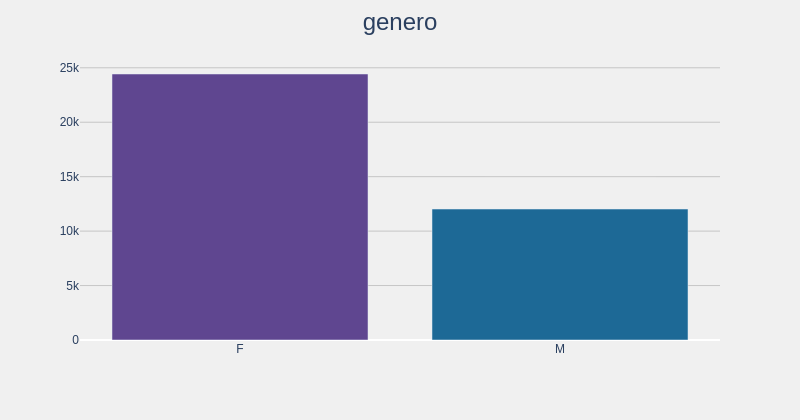

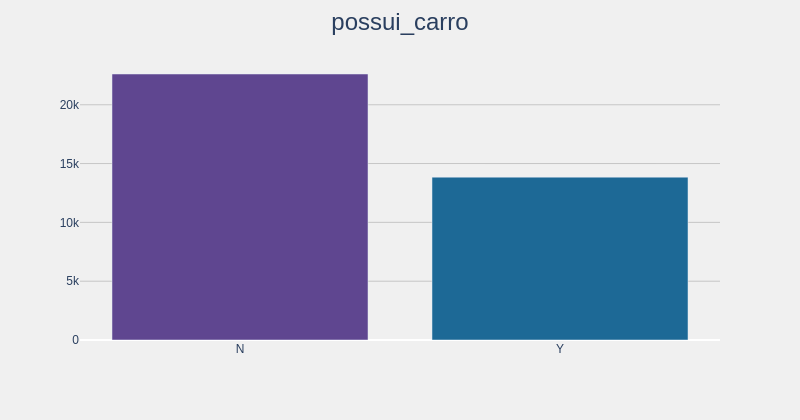

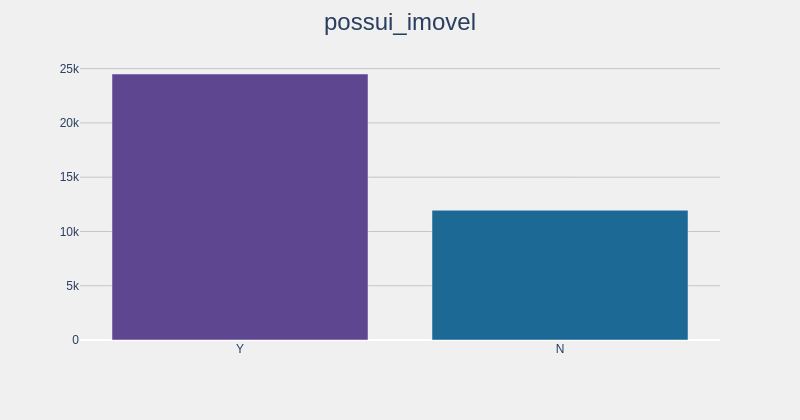

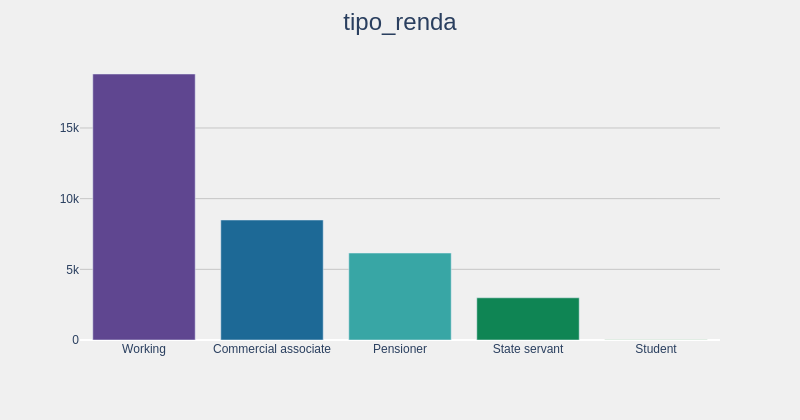

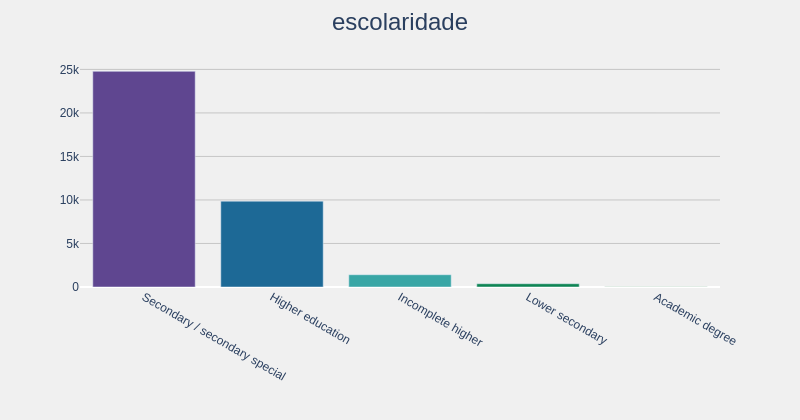

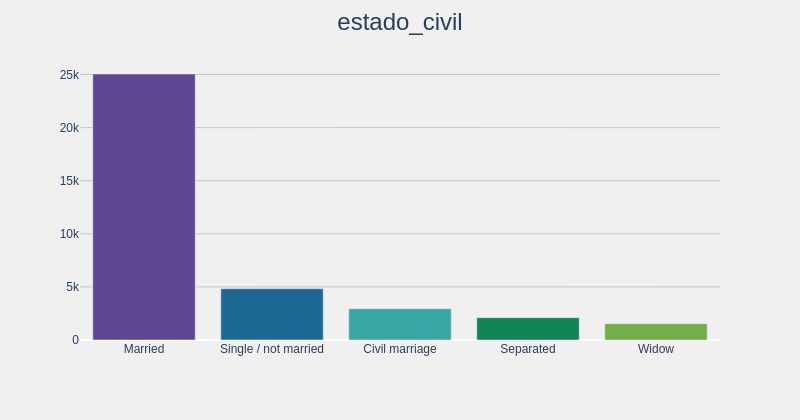

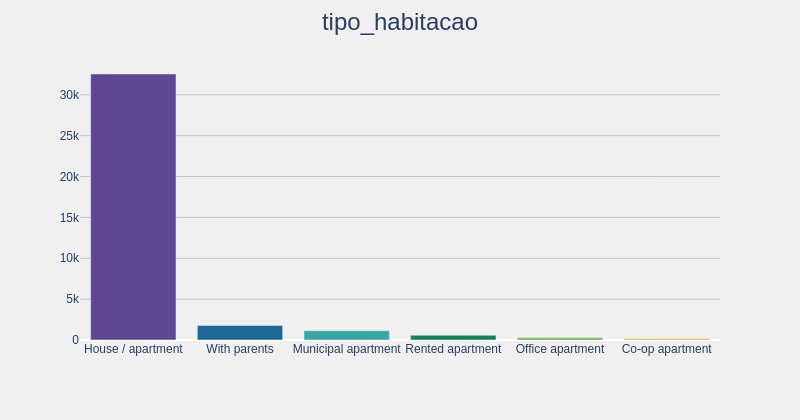

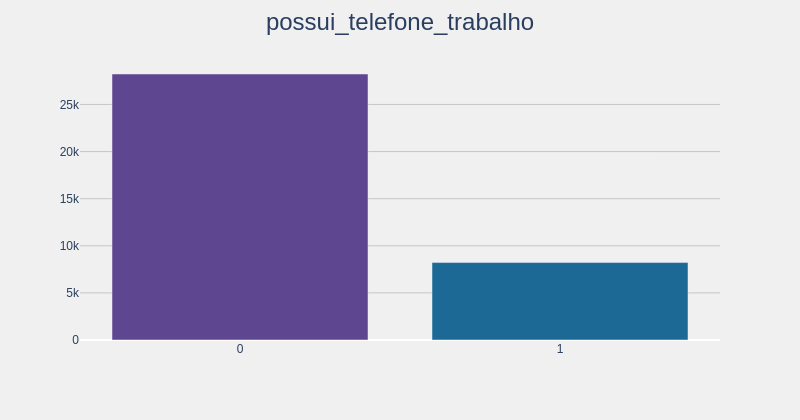

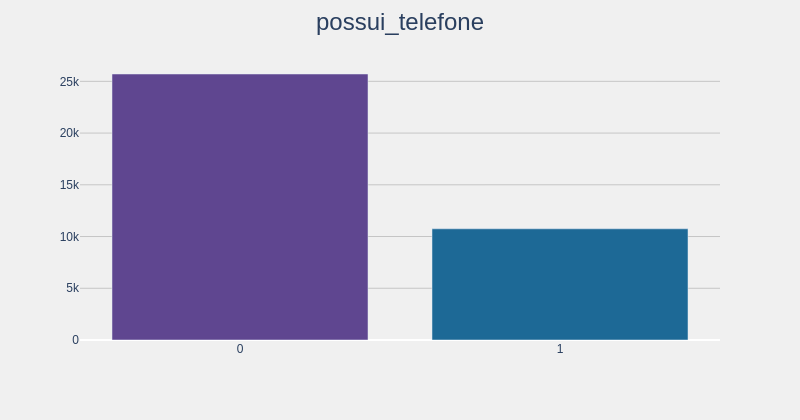

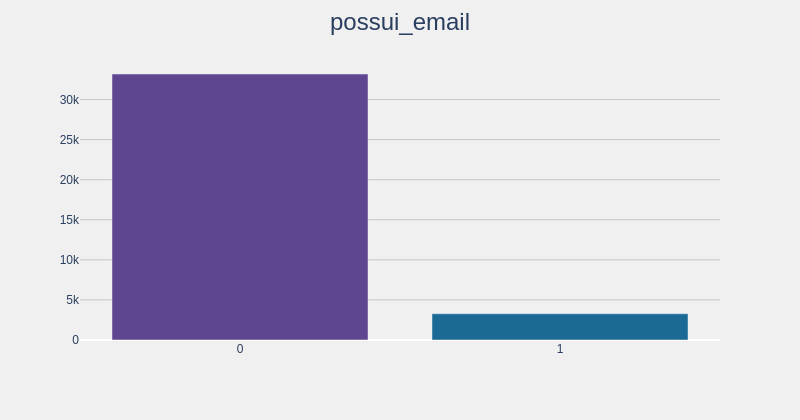

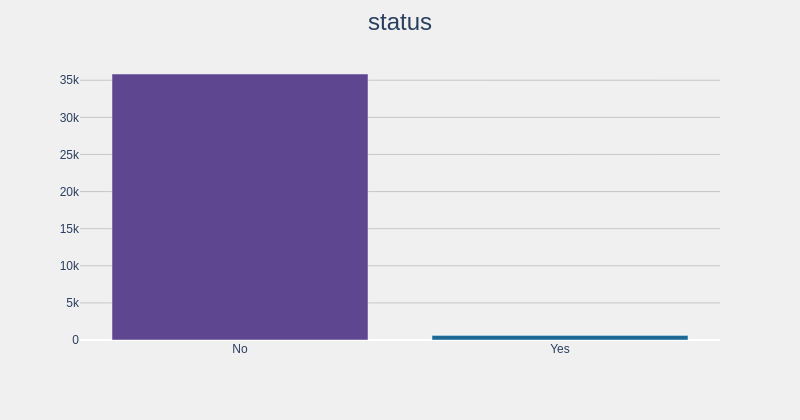

In [33]:
import seaborn as sns
import plotly.express as px
import plotly.colors as pc

# Selecionar apenas as colunas do tipo "object" (variáveis categóricas)
categorical_columns = new_data.select_dtypes(include='object').columns

for column in categorical_columns:
    # Contar a frequência das categorias
    category_counts = new_data[column].value_counts().reset_index()
    category_counts.columns = [column, 'Contagem']

    # Criar um gráfico de barras com Plotly Express
    fig = px.bar(category_counts, x=column, y='Contagem', color=column,
                 color_discrete_sequence=pc.qualitative.Prism)

    # Configurações do gráfico
    fig.update_layout(
        showlegend=False,
        height=420,  # Definir altura do gráfico
        width=800,   # Definir largura do gráfico
        plot_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do plot (cinza)
        paper_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do papel (cinza)
        title=column,
        title_x=0.5,
        title_font=dict(size=24)
    )
    fig.update_xaxes(title_text='')  # Remover a descrição do eixo x
    fig.update_yaxes(title_text='')  # Remover a descrição do eixo y
    fig.update_yaxes(showgrid=True, gridcolor='rgba(100, 100, 100, 0.3)')  # Definir a cor das linhas de grade do eixo y como cinza escuro sutil
    fig.show('png')







Caracterizando a majoritariedade dos clientes atuais:

- Público feminino
- Casados
- Sem filhos
- Com imóvel próprio
- Sem carro
- Com ensino médio
- Clt desenvolvendo atividades comuns

In [ ]:
new_data.dtypes=='object'

genero                       True
possui_carro                 True
possui_imovel                True
qtd_filhos                  False
salario                     False
tipo_renda                   True
escolaridade                 True
estado_civil                 True
tipo_habitacao               True
idade                       False
anos_empregado              False
possui_telefone_trabalho     True
possui_telefone              True
possui_email                 True
qtd_membros_familia         False
meses_desde_inicio          False
status                       True
dtype: bool

# Visualização de variáveis numéricas

In [ ]:
numeric_columns = new_data.select_dtypes(include='number').columns

for column in numeric_columns:
    # Calcular número de bins utilizando a Regra de Freedman-Diaconis
    q25 = new_data[column].quantile(0.25)
    q75 = new_data[column].quantile(0.75)
    iqr = q75 - q25
    lower_bound = q25 - 2 * iqr
    upper_bound = q75 + 2 * iqr

    # Filtrar os dados excluindo os outliers
    filtered_data = new_data[(new_data[column] >= lower_bound) & (new_data[column] <= upper_bound)]

    # Calcular número de bins utilizando a Regra de Freedman-Diaconis para os dados filtrados
    bin_width = (2 * iqr) / (filtered_data[column].shape[0] ** (1/3))
    num_bins = int((filtered_data[column].max() - filtered_data[column].min()) / bin_width)

    # Plotar o histograma utilizando Plotly Express com bins personalizados
    fig = px.histogram(filtered_data, x=column, nbins=num_bins, color_discrete_sequence=pc.qualitative.Prism)
    fig.update_layout(
        showlegend=False,
        height=420,  # Definir altura do gráfico
        width=800,   # Definir largura do gráfico
        plot_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do plot (cinza)
        paper_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do papel (cinza)
        title=column,
        title_x=0.5,
        title_font=dict(size=24)
    )
    fig.update_xaxes(title_text='')  # Remover a descrição do eixo x
    fig.update_yaxes(title_text='')  # Remover a descrição do eixo y
    fig.update_yaxes(showgrid=True, gridcolor='rgba(100, 100, 100, 0.3)')  # Definir a cor das linhas de grade do eixo y como cinza escuro sutil
    fig.show()




In [ ]:
fig = px.histogram(new_data, x='status', barmode='group', color_discrete_sequence=pc.qualitative.Prism)
fig.update_layout(
    showlegend=False,
    height=420,  # Definir altura do gráfico
    width=800,   # Definir largura do gráfico
    plot_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do plot (cinza)
    paper_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do papel (cinza)
    title='Status',
    title_x=0.5,
    title_font=dict(size=24)
)
fig.update_xaxes(title_text='')  # Remover a descrição do eixo x
fig.update_yaxes(title_text='')  # Remover a descrição do eixo y
fig.update_yaxes(showgrid=True, gridcolor='rgba(100, 100, 100, 0.3)')  # Definir a cor das linhas de grade do eixo y como cinza escuro sutil
fig.show()





A variável alvo está claramente desbalanceada, possuindo uma quantidade colossalmente menor de clientes classificados como arriscados devido à presença de, pelo menos, uma transação inadimplente.


## Buscando respostas para as perguntas de negócio:

Para responder aos questionamentos levantados, farei uso de métodos estatísticos como os testes de hipótese. Estes podem ser úteis para identificar padrões e relações entre as variáveis, o que pode ajudar a equipe de negócios a entender melhor o perfil dos clientes e a tomar decisões mais informadas.
Contudo, ressalto que a associação patente entre o comportamento de duas variáveis não determina uma causalidade entre elas.

#1
####De que forma a posse de bens, desde os de menor porte(celular, telefone), aos de maior porte(imóvel, carro) influencia no status do cliente? Há influência?



In [ ]:
posses= ['possui_carro', 'possui_imovel', 'possui_telefone_trabalho', 'possui_telefone']

# Criando uma lista com variáveis que indicam a presença ou não de determindo bem.

Como as variáveis são categóricas, tanto a alvo, quanto as independentes, utilizaremos um teste de hipótese chamado de Chi-quadrado, que é adequado para tais contextos.
É coerente como ferramenta de visualização, ainda, plotar um gráfico de barras empilhadas. Porém, como a classe minoritária é muito menor frente à majoritária, será pouco eficiente, visto que não conseguiremos extrair nenhum tipo de padrão/tendência do gráfico.

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Dados de exemplo
var2 = new_data['status']

# Iterar sobre cada variável categórica da lista posses
for var1 in posses:
    # Filtrar os dados relevantes
    subset = new_data[var1]
    var2_subset = var2

    # Tabela de contingência
    cross_tab = pd.crosstab(var2_subset, subset)

    # Executando o teste de qui-quadrado
    chi2, p_value, _, _ = chi2_contingency(cross_tab)

    # Imprimindo os resultados
    print(f"\033[1m\033[4mAnálise para a variável {var1}:\033[0m")

    print("Tabela de Contingência:")
    display(cross_tab)
    print("\nTeste Qui-quadrado:")
    print("Estatística de Qui-quadrado:", chi2)
    print("Valor de p:", p_value)
    print("-----\n\n")


Análise para a variável possui_carro:
Tabela de Contingência:


possui_carro,N,Y
status,,
No,22222,13619
Yes,392,224



Teste Qui-quadrado:
Estatística de Qui-quadrado: 0.6194683980335078
Valor de p: 0.4312449011656265
-----


Análise para a variável possui_imovel:
Tabela de Contingência:


possui_imovel,N,Y
status,,
No,11700,24141
Yes,251,365



Teste Qui-quadrado:
Estatística de Qui-quadrado: 17.677262108639432
Valor de p: 2.617367302712689e-05
-----


Análise para a variável possui_telefone_trabalho:
Tabela de Contingência:


possui_telefone_trabalho,0,1
status,,
No,27769,8072
Yes,466,150



Teste Qui-quadrado:
Estatística de Qui-quadrado: 1.0574508184389215
Valor de p: 0.303797315016271
-----


Análise para a variável possui_telefone:
Tabela de Contingência:


possui_telefone,0,1
status,,
No,25278,10563
Yes,431,185



Teste Qui-quadrado:
Estatística de Qui-quadrado: 0.0665750324947838
Valor de p: 0.7963904069675544
-----




Com base nos resultados dos testes qui-quadrado, podemos concluir que existe uma associação estatisticamente significativa entre a variável preditora (possui imóvel ou não) e a variável alvo (cliente é arriscado ou não)
Em outras palavras, o fato do cliente possuir imóvel prório, e , portanto, o isentando de lidar com oneração de aluguel, é relevante e influente frente a um contexto de análise de risco.
As demais variáveis não apresentaram associações significativas com o status, de acordo com os testes realizados.

#2
####De que forma as variáveis demográficas se relacionam com o status? Alguma possui papel representativo na variável alvo?



In [ ]:
demograficas=['genero','qtd_membros_familia','tipo_renda','escolaridade','estado_civil']

In [ ]:
# Dados de exemplo
var2 = new_data['status']

# Iterar sobre cada variável categórica da lista posses
for var1 in demograficas:
    # Filtrar os dados relevantes
    subset = new_data[var1]
    var2_subset = var2

    # Tabela de contingência
    cross_tab = pd.crosstab(var2_subset, subset)

    # Executando o teste de qui-quadrado
    chi2, p_value, _, _ = chi2_contingency(cross_tab)

    # Imprimindo os resultados
    print(f"\033[1m\033[4mAnálise para a variável {var1}:\033[0m")
    print("Tabela de Contingência:")
    display(cross_tab)
    print("\nTeste Qui-quadrado:")
    print("Estatística de Qui-quadrado:", chi2)
    print("Valor de p:", p_value)
    print("-----\n\n")

Análise para a variável genero:
Tabela de Contingência:


genero,F,M
status,,
No,24051,11790
Yes,379,237



Teste Qui-quadrado:
Estatística de Qui-quadrado: 8.275267055901836
Valor de p: 0.00401887510426493
-----


Análise para a variável qtd_membros_familia:
Tabela de Contingência:


qtd_membros_familia,1,2,3,4,5,6,7,9,15,20
status,,,,,,,,,,
No,6848,19150,6316,3060,385,57,19,2,3,1
Yes,139,313,105,46,12,1,0,0,0,0



Teste Qui-quadrado:
Estatística de Qui-quadrado: 10.162472512537708
Valor de p: 0.33749306299756693
-----


Análise para a variável tipo_renda:
Tabela de Contingência:


tipo_renda,Commercial associate,Pensioner,State servant,Student,Working
status,,,,,
No,8347,6022,2948,11,18513
Yes,143,130,37,0,306



Teste Qui-quadrado:
Estatística de Qui-quadrado: 10.93195543382093
Valor de p: 0.027339479557413844
-----


Análise para a variável escolaridade:
Tabela de Contingência:


escolaridade,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
status,,,,,
No,32,9693,1377,364,24375
Yes,0,171,33,10,402



Teste Qui-quadrado:
Estatística de Qui-quadrado: 7.113232967578927
Valor de p: 0.1300240123953815
-----


Análise para a variável estado_civil:
Tabela de Contingência:


estado_civil,Civil marriage,Married,Separated,Single / not married,Widow
status,,,,,
No,2899,24655,2072,4728,1487
Yes,46,393,31,101,45



Teste Qui-quadrado:
Estatística de Qui-quadrado: 22.125163119141973
Valor de p: 0.0001892440073295877
-----




Os resultados de P valor mais expressivos se deram nas variáveis:

Gênero, estado_civil e, levemente menos influente que as anteriores, tipo de renda.

Indicando que há perfis de clientes cujas características demográficas fazem-no mais predisposto a entrar em inadimplência.

#3
Possivelmente, levar o rendimento anual em consideração é importante ao definir se o crédito será concedido ou não. Clientes com rendas maiores são melhores pagadores?

In [ ]:

fig = px.box(new_data, x='status', y='salario', color='status',
             color_discrete_sequence=pc.qualitative.Prism)

fig.update_layout(
    showlegend=False,
    height=420,  # Definir altura do gráfico
    width=800,   # Definir largura do gráfico
    plot_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do plot (cinza)
    paper_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do papel (cinza)
    title='Boxplot: Status vs. Salário',
    title_x=0.5,
    title_font=dict(size=24)
)

fig.update_xaxes(title_text='Status')  # Adicionar descrição do eixo x
fig.update_yaxes(title_text='Salário')  # Adicionar descrição do eixo y
fig.update_yaxes(showgrid=True, gridcolor='rgba(100, 100, 100, 0.3)')  # Definir a cor das linhas de grade do eixo y como cinza escuro sutil

fig.show()


Visualmente, não há grande diferença entre as medidas de tendência central média e mediana entre os 2 status.

Os outliers referentes aos salários mais altos estão mais presentes naqueles adimplentes, por razôes óbvias.

#4
O tipo de habitação traz-nos alguma informação em relação à variável alvo ou é pouco relevante? Quem tem casa/apartamento próprio tem menos tendência a não pagar as dívidas?


In [ ]:
# Dados de exemplo
var2 = new_data['status']
var1 = 'tipo_habitacao'

# Filtrar os dados relevantes
subset = new_data[var1].copy()  # Fazer uma cópia para não modificar o DataFrame original
var2_subset = var2

# Transformar as classes em "House / apartment" e "Other"
subset.loc[subset != "House / apartment"] = "Other"

# Tabela de contingência
cross_tab = pd.crosstab(var2_subset, subset)

# Executando o teste de qui-quadrado
chi2, p_value, _, _ = chi2_contingency(cross_tab)

# Imprimindo os resultados
print(f"\033[1m\033[4mAnálise para a variável {var1}:\033[0m")
print("Tabela de Contingência:")
display(cross_tab)
print("\nTeste Qui-quadrado:")
print("Estatística de Qui-quadrado:", chi2)
print("Valor de p:", p_value)



Análise para a variável tipo_habitacao:
Tabela de Contingência:


tipo_habitacao,House / apartment,Other
status,,
No,32008,3833
Yes,540,76



Teste Qui-quadrado:
Estatística de Qui-quadrado: 1.540843664434858
Valor de p: 0.21449227108275432


P valor de 0.21 não é expressivo o suficiente a ponto de considerarmos o tipo de habitação do cliente como informativo.
Apesar de não possuir caráter definitivo, principalmente em dados desbalanceados, os testes de hipóteses são importantes para analisar a relação entre as variáveis..

In [ ]:
new_data.columns

Index(['genero', 'possui_carro', 'possui_imovel', 'qtd_filhos', 'salario',
       'tipo_renda', 'escolaridade', 'estado_civil', 'tipo_habitacao', 'idade',
       'anos_empregado', 'possui_telefone_trabalho', 'possui_telefone',
       'possui_email', 'qtd_membros_familia', 'meses_desde_inicio', 'status'],
      dtype='object')

#5
O tempo contínuo total que o cliente possui empregado faz o status ter algum comportamento peculiar?

Temos muitos matusalém's no gráfico.... com 1000 anos empregados...

Brincadeiras à parte, filtraremos para excluir tais valores.

In [ ]:
import plotly.express as px

# Filtrar os dados de anos_empregado abaixo de 1000
filtered_data = new_data[new_data['anos_empregado'] > -1000]

fig = px.box(filtered_data, x='status', y='anos_empregado', color='status',
             color_discrete_sequence=pc.qualitative.Prism)

fig.update_layout(
    showlegend=False,
    height=420,  # Definir altura do gráfico
    width=800,   # Definir largura do gráfico
    plot_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do plot (cinza)
    paper_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do papel (cinza)
    title='Boxplot: Status vs. Anos empregado',
    title_x=0.5,
    title_font=dict(size=24)
)

fig.update_xaxes(title_text='Status')  # Adicionar descrição do eixo x
fig.update_yaxes(title_text='Anos empregado')  # Adicionar descrição do eixo y
fig.update_yaxes(showgrid=True, gridcolor='rgba(100, 100, 100, 0.3)')  # Definir a cor das linhas de grade do eixo y como cinza escuro sutil

fig.show()


In [ ]:
  from scipy.stats import f_oneway

# Dados de exemplo
var1 = 'status'
var2 = 'anos_empregado'

# Filtrar os dados relevantes
filtered_data = new_data[new_data[var2] > -1000]
subset1 = filtered_data[filtered_data[var1] == 'No'][var2]
subset2 = filtered_data[filtered_data[var1] == 'Yes'][var2]

# Realizar o teste ANOVA
f_value, p_value = f_oneway(subset1, subset2)

print("\nTeste ANOVA:")
print("Estatística F:", f_value)
print("Valor de p:", p_value)


Teste ANOVA:
Estatística F: 18.775687191294807
Valor de p: 1.475021823546719e-05


O Valor P resultante é consideravelmente pequeno.
Graficamente via boxplot, pudemos observar que a mediana de anos empregados é cerca de 1 ano maior em clientes adimplentes.
Porém, como há uma presença considerável de outliers distorcendo a média, não poderemos concluir assertivamente uma associação.

#6
E a idade? Clientes mais jovens são menos prudentes e, por conseguinte, mais inadimplentes?

In [ ]:
fig = px.box(new_data, x='status', y='idade', color='status',
             color_discrete_sequence=pc.qualitative.Prism)

fig.update_layout(
    showlegend=False,
    height=420,  # Definir altura do gráfico
    width=800,   # Definir largura do gráfico
    plot_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do plot (cinza)
    paper_bgcolor='rgba(240,240,240,1)',  # Definir cor de fundo do papel (cinza)
    title='Boxplot: Status vs. Idade',
    title_x=0.5,
    title_font=dict(size=24)
)

fig.update_xaxes(title_text='Status')  # Adicionar descrição do eixo x
fig.update_yaxes(title_text='Idade')  # Adicionar descrição do eixo y
fig.update_yaxes(showgrid=True, gridcolor='rgba(100, 100, 100, 0.3)')  # Definir a cor das linhas de grade do eixo y como cinza escuro sutil


Parecem boxplot idênticos... ter ciência da idade não agregou à análise.

In [ ]:
from scipy.stats import f_oneway

# Dados de exemplo
var1 = 'status'
var2 = 'idade'

# Obter os grupos
subset1 = new_data[new_data[var1] == 'No'][var2]
subset2 = new_data[new_data[var1] == 'Yes'][var2]

# Realizar o teste ANOVA
f_value, p_value = f_oneway(subset1, subset2)

# Imprimir os resultados
print("\nTeste ANOVA:")
print("Estatística F:", f_value)
print("Valor de p:", p_value)



Teste ANOVA:
Estatística F: 0.10502278653904475
Valor de p: 0.7458852375118521


P valor muito grande... ratificando o que visualizamos graficamente.

#Preprocessamento dos dados

##Limpando outliers

O Local Outlier Factor (LOF) é um algoritmo de detecção de outliers não supervisionado usado para identificar pontos anômalos em um conjunto de dados. Ele foi proposto por Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng e Jörg Sander em 2000.

A ideia fundamental do LOF é avaliar a densidade local de cada ponto de dados em relação a seus vizinhos. Pontos que possuem uma densidade local significativamente menor em comparação com seus vizinhos são considerados outliers. O LOF leva em conta as características locais dos dados, o que o torna adequado para detectar outliers em grupos de diferentes densidades e formas.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

colunas_numericas = new_data.select_dtypes(include=['float', 'int']).columns.tolist()

# Converter o DataFrame para um array numpy
X = new_data[colunas_numericas].values

# Criar o modelo LocalOutlierFactor
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Ajustar o modelo e obter os rótulos de outliers (-1 indica outlier, 1 indica inlier)
outlier_labels = lof_model.fit_predict(X)

# Obter os dados limpos (sem outliers)
new_data = new_data[outlier_labels != -1]

# Imprimir o número de outliers detectados e removidos
num_outliers = np.sum(outlier_labels == -1)
print(f"Número de outliers detectados e removidos: {num_outliers}")

# Agora, 'dados_limpos' contém o conjunto de dados sem outliers

Número de outliers detectados e removidos: 1823


In [ ]:
new_data

,genero,possui_carro,possui_imovel,qtd_filhos,salario,tipo_renda,escolaridade,estado_civil,tipo_habitacao,idade,anos_empregado,possui_telefone_trabalho,possui_telefone,possui_email,qtd_membros_familia,meses_desde_inicio,status
0,M,Y,Y,0,35625.0,Working,Higher education,Civil marriage,Rented apartment,33,12.4,1,0,0,2,-15,No
1,M,Y,Y,0,35625.0,Working,Higher education,Civil marriage,Rented apartment,33,12.4,1,0,0,2,-14,No
2,M,Y,Y,0,9375.0,Working,Secondary / secondary special,Married,House / apartment,59,3.1,0,0,0,2,-29,No
3,F,N,Y,0,22500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8.4,0,1,1,1,-4,No
4,F,N,Y,0,22500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8.4,0,1,1,1,-26,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,M,Y,Y,0,26250.0,Working,Secondary / secondary special,Married,House / apartment,48,6.6,0,0,0,2,-11,Yes
36453,F,N,Y,0,13125.0,Commercial associate,Higher education,Married,House / apartment,34,3.6,0,1,1,2,-23,Yes
36454,F,N,Y,0,13125.0,Pensioner,Higher education,Married,House / apartment,34,3.6,0,1,1,2,-32,Yes
36455,F,N,Y,0,23625.0,Working,Secondary / secondary special,Married,House / apartment,49,1.8,0,0,0,2,-9,Yes


In [ ]:
# Labelencoder na variável alvo
new_data['status'] = new_data['status'].map(lambda x: 1 if x == 'Yes' else 0)


In [ ]:
#Aplicando transformação logarítmica na variável assimétrica 'anos_empregado' e 'salario

new_data = new_data[new_data['anos_empregado'] > 0] #Excluindo quem já saiu da empresa

new_data['anos_empregado']= np.log(new_data['anos_empregado'])
new_data['salario']= np.log(new_data['salario'])

#Criando Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Define transformadores para colunas numéricas e categóricas

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Preenche valores ausentes com a média
    ('scaler', StandardScaler())  # Padroniza os valores numéricos
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Preenche valores ausentes com 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))  # Codifica variáveis categóricas usando one-hot encoding
])


# Atualiza as colunas categóricas e numéricas

categorical_columns = new_data.select_dtypes(include=['object', 'category']).columns
numerical_columns = new_data.select_dtypes(include=['int64', 'float64']).columns

# Remove a variável alvo das colunas numéricas

numerical_columns = numerical_columns.drop('status')

# Combina os transformadores usando o ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Cria um pipeline com o pré-processador

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplica o pipeline ao seu conjunto de dados

x = new_data.drop('status', axis=1)
y = new_data['status']
x_final = pipeline.fit_transform(x)

# Obtém os nomes das colunas após o pré-processamento

feature_names = preprocessor.get_feature_names_out()


# Imprime a ordem das colunas após o pré-processamento

print("Ordem das colunas depois de preprocessar:")
print(feature_names)




Ordem das colunas depois de preprocessar:
['num__qtd_filhos' 'num__salario' 'num__idade' 'num__anos_empregado'
 'num__qtd_membros_familia' 'num__meses_desde_inicio' 'cat__genero_M'
 'cat__possui_carro_Y' 'cat__possui_imovel_Y' 'cat__tipo_renda_Pensioner'
 'cat__tipo_renda_State servant' 'cat__tipo_renda_Student'
 'cat__tipo_renda_Working' 'cat__escolaridade_Higher education'
 'cat__escolaridade_Incomplete higher' 'cat__escolaridade_Lower secondary'
 'cat__escolaridade_Secondary / secondary special'
 'cat__estado_civil_Married' 'cat__estado_civil_Separated'
 'cat__estado_civil_Single / not married' 'cat__estado_civil_Widow'
 'cat__tipo_habitacao_House / apartment'
 'cat__tipo_habitacao_Municipal apartment'
 'cat__tipo_habitacao_Office apartment'
 'cat__tipo_habitacao_Rented apartment' 'cat__tipo_habitacao_With parents'
 'cat__possui_telefone_trabalho_1' 'cat__possui_telefone_1'
 'cat__possui_email_1']




---



---



---



###Variance Inflation Factor

Já que agora os dados estão preprocessados, irei realizar o cálculo do VIF(variance_inflation_factor, a fim de observar se há forte multicolinearidade entre as variáveis.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular o VIF para cada variável explicativa
vif = pd.DataFrame()
vif["Feature"] = feature_names
vif["VIF"] = [variance_inflation_factor(x_final, i) for i in range(x_final.shape[1])]
# Ordenar o DataFrame vif em ordem ascendente com base na coluna "VIF"
vif_sorted = vif.sort_values(by="VIF", ascending=True)

# Imprimir o DataFrame ordenado
display(vif_sorted)

,Feature,VIF
9,cat__tipo_renda_Pensioner,1.003572
11,cat__tipo_renda_Student,1.004859
5,num__meses_desde_inicio,1.018691
3,num__anos_empregado,1.113018
28,cat__possui_email_1,1.149719
1,num__salario,1.211461
2,num__idade,1.324429
10,cat__tipo_renda_State servant,1.386749
27,cat__possui_telefone_1,1.653255
26,cat__possui_telefone_trabalho_1,1.680787


### O problema de multicolinearidade

*"Um VIF menor que 5 indica uma baixa correlação daquela variável preditora com as outras variáveis preditoras. Um valor entre 5 e 10 indica uma correlação moderada, enquanto valores de VIF maiores que 10 são um sinal de alta correlação, não tolerável, entre os preditores do modelo." (James et al., 2013).*

De acordo com James, os resultados acima expostos demonstram intensa multicolinearidade, possivelmente devido à quantidade de variáveis categóricas multi_classes presentes.

Farei uma pequena engenharia de features a fim de reduzir a multicolinearidade de algumas variáveis.



Quase metade das variáveis estão com um VIF

In [ ]:
# Codificar a variável "estado_civil"
new_data["estado_civil"] = new_data["estado_civil"].map(lambda x: "Married" if x == "Married" else "not_Married")


In [ ]:
new_data["estado_civil"] = new_data["estado_civil"].map(lambda x: "Married" if x == "Married" else "not_Married")

Consideraremos todos a classe "Working" como sendo CLT.
Juntaremos "Working" com "commercial associate" representandos o mercado privado.
As demais representando uma renda advinda do setor público.


In [ ]:
new_data["tipo_renda"] = new_data["tipo_renda"].map(lambda x: "Private income" if x == "Commercial associate" or x== "Working" else "Public income")

In [ ]:
new_data["escolaridade"] = new_data["escolaridade"].map(lambda x: "Has Higher education" if x == "Higher education" else "Has not Higher education")


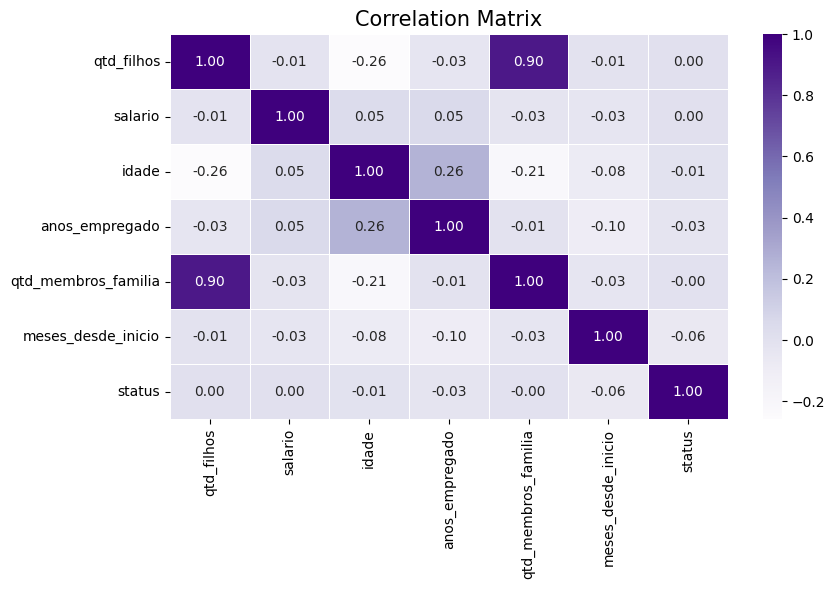

In [ ]:
# Calculando a matriz de correlação
correlation_matrix = new_data.corr()

# Criando um mapa de calor com seaborn
plt.figure(figsize=(9, 5))
sns.heatmap(correlation_matrix, cmap='Purples', annot=True, fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix', size=15)
plt.show()


In [ ]:
new_data.drop(columns=['qtd_membros_familia','qtd_filhos','tipo_habitacao'], axis=1, inplace=True)

Anos_empregado possui alta correlação com a idade.

#Preprocessando novamente...

In [ ]:
# Atualiza as colunas categóricas e numéricas

categorical_columns = new_data.select_dtypes(include=['object', 'category']).columns
numerical_columns = new_data.select_dtypes(include=['int64', 'float64']).columns

# Remove a variável alvo das colunas numéricas

numerical_columns = numerical_columns.drop('status')

# Combina os transformadores usando o ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ], remainder='passthrough')

# Cria um pipeline com o pré-processador

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplica o pipeline ao seu conjunto de dados

x = new_data.drop('status', axis=1)
y = new_data['status']
x_final = pipeline.fit_transform(x)


# Obtém os nomes das colunas após o pré-processamento

feature_names = preprocessor.get_feature_names_out()


# Imprime a ordem das colunas após o pré-processamento

print("Ordem das colunas depois de preprocessar:")
print(feature_names)


Ordem das colunas depois de preprocessar:
['num__salario' 'num__idade' 'num__anos_empregado'
 'num__meses_desde_inicio' 'cat__genero_M' 'cat__possui_carro_Y'
 'cat__possui_imovel_Y' 'cat__tipo_renda_Public income'
 'cat__escolaridade_Has not Higher education'
 'cat__estado_civil_not_Married' 'cat__possui_telefone_trabalho_1'
 'cat__possui_telefone_1' 'cat__possui_email_1']


In [ ]:
# Calcular o VIF para cada variável explicativa
vif = pd.DataFrame()
vif["Feature"] = feature_names
vif["VIF"] = [variance_inflation_factor(x_final, i) for i in range(x_final.shape[1])]
# Ordenar o DataFrame vif em ordem ascendente com base na coluna "VIF"
vif_sorted = vif.sort_values(by="VIF", ascending=True)

# Imprimir o DataFrame ordenado
display(vif_sorted)

,Feature,VIF
3,num__meses_desde_inicio,1.016852
7,cat__tipo_renda_Public income,1.095228
2,num__anos_empregado,1.105082
12,cat__possui_email_1,1.122692
1,num__idade,1.125675
0,num__salario,1.175575
9,cat__estado_civil_not_Married,1.370869
10,cat__possui_telefone_trabalho_1,1.578621
11,cat__possui_telefone_1,1.580076
5,cat__possui_carro_Y,1.845321


Aparentemente, problema resolvido com sucesso.

# Modelagem

Ao lidar com dados desbalanceados, é pouco eficiente utilizar acurácia/precision como métrica de avalição.
Então, me apropriei do F1-score para análise de perfomance de alguns modelos de classificação.

O F1-score é uma métrica de avaliação que combina a precisão e o recall em um único valor. É especialmente útil em conjuntos de dados desbalanceados, onde uma classe é mais frequente que a outra. O F1-score considera tanto falsos positivos quanto falsos negativos, fornecendo uma medida equilibrada do desempenho do modelo. É uma métrica importante ao avaliar a capacidade do modelo de identificar corretamente exemplos da classe minoritária.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from imblearn.over_sampling import SMOTE




from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, y, test_size=0.2, random_state=42, shuffle=True)

X_train, y_train = SMOTE().fit_resample(X_train, y_train)


In [ ]:
# Define os modelos
models = {
    'XGBoost': xgb.XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression()
}



# Define as grades de hiperparâmetros para cada modelo
param_distributions = {
    'XGBoost': {
        'n_estimators': [100, 200, 500, 700, 1000],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10],
        'scale_pos_weight': [3, 5, 9],  # Defina valores apropriados com base na proporção das classes
        'max_delta_step': [1, 2, 5, 10]  # Experimente valores pequenos
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500, 700, 1000],
        'max_depth': [None] + [np.random.randint(10, 31)],
        'min_samples_split': list(np.random.randint(2, 11, size=5)),
        'class_weight': [None, 'balanced', 'balanced_subsample'],  # Utiliza pesos balanceados para as classes

    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

# Realiza a tunagem de hiperparâmetros e avaliação dos modelos
melhores_resultados = {}
for nome_modelo, modelo in models.items():
    busca_aleatoria = RandomizedSearchCV(estimator=modelo, param_distributions=param_distributions[nome_modelo], scoring='roc_auc', cv=3, n_iter=10, random_state=42)
    busca_aleatoria.fit(x_final, y)

    melhores_parametros = busca_aleatoria.best_params_
    melhor_auc_score = busca_aleatoria.best_score_

    melhores_resultados[nome_modelo] = melhor_auc_score

    print(f"Melhores parâmetros para {nome_modelo}: {melhores_parametros}")
    print(f"Melhor pontuação AUC para {nome_modelo}: {melhor_auc_score}\n")

# Imprime os resultados finais
print("Resultados finais:")
for nome_modelo, pontuacao in melhores_resultados.items():
    print(f"Pontuação AUC para {nome_modelo}: {pontuacao}")

Melhores parâmetros para XGBoost: {'scale_pos_weight': 9, 'n_estimators': 700, 'max_depth': 6, 'max_delta_step': 10, 'learning_rate': 0.3}
Melhor pontuação AUC para XGBoost: 0.6140456639522053

Melhores parâmetros para Random Forest: {'n_estimators': 700, 'min_samples_split': 6, 'max_depth': None, 'class_weight': 'balanced'}
Melhor pontuação AUC para Random Forest: 0.592299707678326

Melhores parâmetros para Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Melhor pontuação AUC para Logistic Regression: 0.591830222001489

Resultados finais:
Pontuação AUC para XGBoost: 0.6140456639522053
Pontuação AUC para Random Forest: 0.592299707678326
Pontuação AUC para Logistic Regression: 0.591830222001489


O modelo vencedor foi o XGBoost!

Configurarei o escopo de valores para o threshold(corte de probabilidade do modelo) entre 0 e 0.20, visto que a densa maioria dos valores se concentra neste intervalo.

In [ ]:
from sklearn.metrics import recall_score, precision_score
import plotly.graph_objects as go


# Criar e treinar o modelo XGBoost
model = xgb.XGBClassifier(scale_pos_weight=9, n_estimators= 700, max_depth=6, max_delta_step=10, learning_rate=0.3)
model.fit(X_train, y_train)

# Obter as previsões do modelo no conjunto de teste
y_pred = model.predict_proba(X_test)[:, 1]

# Função para calcular o recall para um determinado threshold
def calculate_recall(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(int)
    return recall_score(y_true, y_pred_binary)

# Função para calcular a precision para um determinado threshold
def calculate_precision(y_true, y_pred, threshold):
    y_pred_binary = (y_pred >= threshold).astype(int)
    return precision_score(y_true, y_pred_binary)

# Número de thresholds reduzido
num_thresholds = 20

# Valores de threshold espaçados uniformemente
thresholds = np.linspace(0, 0.40, num=num_thresholds)
thresholds_precision_recall = np.linspace(0, 1, num=num_thresholds)

# Calcula os F1-scores e recalls para cada threshold
f1_scores = []
recalls = []
precisions = []

for threshold in thresholds:
    recall = calculate_recall(y_test, y_pred, threshold)
    precision = calculate_precision(y_test, y_pred, threshold)
    recalls.append(recall)
    precisions.append(precision)

for threshold in thresholds_precision_recall:
    recall = calculate_recall(y_test, y_pred, threshold)
    precision = calculate_precision(y_test, y_pred, threshold)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    f1_scores.append(f1_score)

# Criar o gráfico da curva F1-score
fig_f1 = go.Figure()
fig_f1.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1-score', line=dict(color='purple')))
fig_f1.update_layout(
    height=420,
    width=800,
    plot_bgcolor='rgba(240,240,240,1)',
    paper_bgcolor='rgba(240,240,240,1)',
    title='F1-score',
    title_x=0.5,
    title_font=dict(size=24),
    xaxis_title='Threshold',
    yaxis_title='F1-score',
    showlegend=False
)
fig_f1.update_xaxes(showline=True, linewidth=2, linecolor='lightgrey', mirror=True)
fig_f1.update_yaxes(showline=True, linewidth=2, linecolor='lightgrey', mirror=True)

# Criar o gráfico da curva Precision-Recall
fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(x=recalls, y=precisions, mode='lines', name='Precision-Recall Curve',line=dict(color='purple')))
fig_pr.update_layout(
    height=420,
    width=800,
    plot_bgcolor='rgba(240,240,240,1)',
    paper_bgcolor='rgba(240,240,240,1)',
    title='Precision-Recall Curve',
    title_x=0.5,
    title_font=dict(size=24),
    xaxis_title='Recall',
    yaxis_title='Precision',
    showlegend=False
)
fig_pr.update_xaxes(showline=True, linewidth=2, linecolor='lightgrey', mirror=True)
fig_pr.update_yaxes(showline=True, linewidth=2, linecolor='lightgrey', mirror=True)

# Mostrar os gráficos
fig_f1.show()
fig_pr.show()



Um possível ponto relevante para configurarmos o Threshold aparenta estar entre 0 e 0.01.
Porém, para definir de forma segura o ponto corte de probabilidade, deveríamos analisar a estrutura de custos, ou seja, construir uma Matrix de confusão comportando os custos de cada possibilidade e realizar o cálculo do valor esperado.



In [ ]:
len(X_train)

45892

In [ ]:
new_data

,genero,possui_carro,possui_imovel,salario,tipo_renda,escolaridade,estado_civil,idade,anos_empregado,possui_telefone_trabalho,possui_telefone,possui_email,meses_desde_inicio,status
0,M,Y,Y,10.480803,Private income,Has Higher education,not_Married,33,2.517696,1,0,0,-15,0
1,M,Y,Y,10.480803,Private income,Has Higher education,not_Married,33,2.517696,1,0,0,-14,0
2,M,Y,Y,9.145802,Private income,Has not Higher education,Married,59,1.131402,0,0,0,-29,0
3,F,N,Y,10.021271,Private income,Has not Higher education,not_Married,52,2.128232,0,1,1,-4,0
4,F,N,Y,10.021271,Private income,Has not Higher education,not_Married,52,2.128232,0,1,1,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,M,Y,Y,10.175421,Private income,Has not Higher education,Married,48,1.887070,0,0,0,-11,1
36453,F,N,Y,9.482274,Private income,Has Higher education,Married,34,1.280934,0,1,1,-23,1
36454,F,N,Y,9.482274,Public income,Has Higher education,Married,34,1.280934,0,1,1,-32,1
36455,F,N,Y,10.070061,Private income,Has not Higher education,Married,49,0.587787,0,0,0,-9,1


In [ ]:
new_data['status'].value_counts()

0    28683
1      489
Name: status, dtype: int64

Utilizei um Corte consideravelmente ínfimo, porém funcional diante da nossa necessidade de melhorar o Recall a custo do Precision.

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict_proba(X_test)[:, 1]

# Definir o threshold
threshold = 0.000005

# Obter as previsões do modelo no conjunto de teste
y_pred_threshold = (y_pred >= threshold).astype(int)

# Exibir o classification report
print(classification_report(y_test, y_pred_threshold))


              precision    recall  f1-score   support

           0       0.99      0.23      0.37      5737
           1       0.02      0.90      0.04        98

    accuracy                           0.24      5835
   macro avg       0.51      0.56      0.20      5835
weighted avg       0.98      0.24      0.37      5835



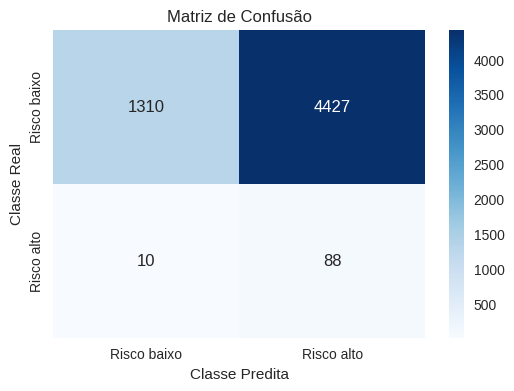

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Suponha que você tem as classes reais y_test e as previsões binárias y_pred_threshold

# Calcule a matriz de confusão
cm = confusion_matrix(y_test, y_pred_threshold)

# Defina os rótulos das classes
class_labels = ['Risco baixo', 'Risco alto']

# Crie um heatmap usando a biblioteca Seaborn para melhor visualização
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Adicione rótulos e título
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')

# Mostrar o plot
plt.show()


O algoritmo ainda possui dificuldades ao prever a classe minoritária.
Threshold= 0.03 foi o corte que melhorou o Recall.

In [ ]:
importances = model.feature_importances_

# Ordenar as importâncias e as features em ordem ascendente
sorted_features = sorted(zip(feature_names, importances), key=lambda x: x[1])

# Exibir as importâncias das features em ordem ascendente
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


num__anos_empregado: 0.024576321244239807
num__meses_desde_inicio: 0.025201264768838882
num__idade: 0.04094703868031502
num__salario: 0.04726933687925339
cat__possui_carro_Y: 0.0755266398191452
cat__genero_M: 0.08026201277971268
cat__possui_imovel_Y: 0.08546839654445648
cat__escolaridade_Has not Higher education: 0.08675282448530197
cat__possui_telefone_trabalho_1: 0.0916716679930687
cat__estado_civil_not_Married: 0.09451548010110855
cat__possui_telefone_1: 0.09767953306436539
cat__possui_email_1: 0.1116936206817627
cat__tipo_renda_Public income: 0.13843588531017303


In [ ]:
new_data_copy= new_data

# Recomendações finais



Após a realização de testes estatísticos como Chi-quadrado e Anova a fim de checar possíveis associações entre as features disponíveis no dataset e a variável alvo, concluímos, após estabelecer nível de significância(5%):

- Possuir informações demográficas acerca dos clientes possui importância ao analisar risco de crédito. Em especial, seu estado civil, gênero e tipo de renda.
- Posse de bens como imóvel contribuem ao classificar o score de risco.
- Clientes cujo tempo empregado é maior se apresentam como menos arriscados frente aos demais.




In [ ]:
# Selecionar as features que serão usadas no treinamento do pipeline
selected_features = ['casado',
                     'possui_carro',
                     'possui_imovel',
                     'ensino_superior',
                     'salario',
                     'idade']

In [ ]:
deploy_df = new_data

deploy_df['casado'] = deploy_df['estado_civil'].map({'Married': 1, 'not_Married': 0})
deploy_df['ensino_superior'] = deploy_df['escolaridade'].map({'Has Higher education': 1, 'Has not Higher education': 0})
deploy_df['possui_carro'] = deploy_df['possui_carro'].map({'Y': 1, 'N': 0})
deploy_df['possui_imovel'] = deploy_df['possui_imovel'].map({'Y': 1, 'N': 0})
deploy_df= deploy_df[selected_features]

In [ ]:
deploy_df.dtypes

casado               int64
possui_carro         int64
possui_imovel        int64
ensino_superior      int64
salario            float64
idade                int64
dtype: object

In [ ]:
# Colunas que serão preprocessadas com StandardScaler
cols_to_scale = ['salario', 'idade']

# Colunas que serão mantidas intactas (binárias categóricas)
cols_to_keep = ['casado', 'possui_carro', 'possui_imovel', 'ensino_superior']

# Criando os transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), cols_to_scale)  # StandardScaler para colunas numéricas
    ],
    remainder='passthrough'  # Mantém as colunas categóricas intactas
)



In [ ]:
from sklearn.model_selection import cross_val_score

# Dividir o DataFrame em features (X) e rótulo (y)
x_deploy = deploy_df
y_deploy = new_data['status']

x_deploy.reset_index(drop=True, inplace=True)
y_deploy.reset_index(drop=True, inplace=True)

# Criar o modelo XGBoost
X_train_deploy, X_test_deploy, y_train_deploy, y_test_deploy = train_test_split(x_deploy, y, test_size=0.2, random_state=42, shuffle=True)

X_train_deploy, y_train_deploy = SMOTE().fit_resample(X_train_deploy, y_train_deploy)

model_deploy = xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1)

# Definir o pipeline com o modelo como último passo, usando somente as features selecionadas
pipeline_deploy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_deploy)
])

# Treinar o pipeline somente com as features selecionadas usando o conjunto completo
model_deploy.fit(X_train_deploy, y_train_deploy)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
import os
import pickle

# Caminho completo para a pasta 'DataSet' no Google Drive
folder_path = '/content/drive/MyDrive/DataSet/'



# Caminho completo para o arquivo .pkl no Google Drive
file_path = os.path.join(folder_path, 'pipeline_with_model.pkl')

# Salvar o pipeline em um arquivo .pkl no Google Drive
with open(file_path, 'wb') as file:
    pickle.dump(model_deploy, file)

In [ ]:
# Supondo que você esteja usando um modelo baseado em árvore, como Random Forest ou Decision Tree
importance_values = model.feature_importances_

# Supondo que você tenha as colunas de entrada do modelo em uma lista chamada "feature_names"
feature_names = ["casado", "possui_carro", "possui_imovel", "ensino_superior", "salario", "idade"]

# Exibir as importâncias de cada característica com seus respectivos nomes
for feature_name, importance in zip(feature_names, importance_values):
    print(f"{feature_name}: {importance}")



casado: 0.04726933687925339
possui_carro: 0.04094703868031502
possui_imovel: 0.024576321244239807
ensino_superior: 0.025201264768838882
salario: 0.08026201277971268
idade: 0.0755266398191452
